In [5]:
# Cell 1 — Setup & imports
%matplotlib inline
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

print("Libraries loaded. Colab ready.")


Libraries loaded. Colab ready.


In [6]:
# Cell 2 — (Optional) install — uncomment if you get missing-package errors
!pip install -q scikit-learn pandas matplotlib seaborn


In [7]:
# Cell 3 — Upload your dataset (CSV or Excel)
from google.colab import files
uploaded = files.upload()  # a file picker appears

if not uploaded:
    raise SystemExit("No file uploaded. Please rerun this cell and upload a CSV/XLSX file.")

# pick first uploaded file
fname = list(uploaded.keys())[0]
print("Uploaded file:", fname)

# read file robustly
ext = os.path.splitext(fname)[1].lower()
if ext == ".csv":
    df = pd.read_csv(io.BytesIO(uploaded[fname]))
elif ext in [".xls", ".xlsx"]:
    df = pd.read_excel(io.BytesIO(uploaded[fname]))
else:
    raise ValueError("Unsupported file type: " + ext)

print("Data loaded. Shape:", df.shape)
df.head()


Saving Mall_Customers.csv to Mall_Customers (1).csv
Uploaded file: Mall_Customers (1).csv
Data loaded. Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [8]:
# Cell 4 — Quick EDA
print("Columns:", df.columns.tolist())
display(df.info())
display(df.describe().T)
print("Missing values per column:")
print(df.isnull().sum())


Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


Missing values per column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [9]:
# Cell 5 — Choose numeric features (common heuristics)
# If the dataset is the Mall Customers dataset, pick canonical columns.
if set(['Annual Income (k$)', 'Spending Score (1-100)']).issubset(df.columns):
    features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
else:
    # pick numeric columns, drop obvious id columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if not c.lower().startswith('id')]
    if len(numeric_cols) == 0:
        raise SystemExit("No numeric features found. Please upload a dataset with numeric columns or preprocess categorical features first.")
    features = numeric_cols

# if Gender exists, encode it
if 'Gender' in df.columns and 'Gender' not in features:
    df['Gender_encoded'] = df['Gender'].astype('category').cat.codes
    features.append('Gender_encoded')

print("Features used for clustering:", features)

# prepare X
X = df[features].copy()
# drop rows with NA in selected features
X = X.dropna(axis=0)
print("After dropping NA, shape:", X.shape)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features used for clustering: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_encoded']
After dropping NA, shape: (200, 4)


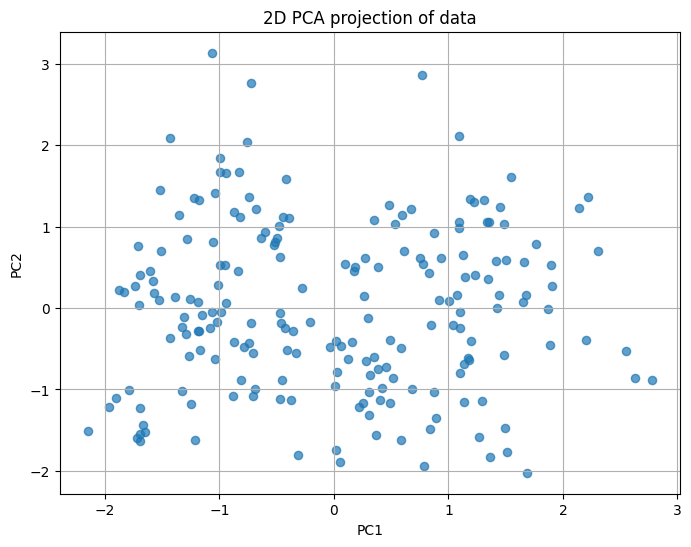

In [10]:
# Cell 6 — PCA to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=35, alpha=0.7)
plt.title("2D PCA projection of data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


k=2 -> silhouette score = 0.2518
k=3 -> silhouette score = 0.2595
k=4 -> silhouette score = 0.2984
k=5 -> silhouette score = 0.3041
k=6 -> silhouette score = 0.3311
k=7 -> silhouette score = 0.3574
k=8 -> silhouette score = 0.3880
k=9 -> silhouette score = 0.4031
k=10 -> silhouette score = 0.4208


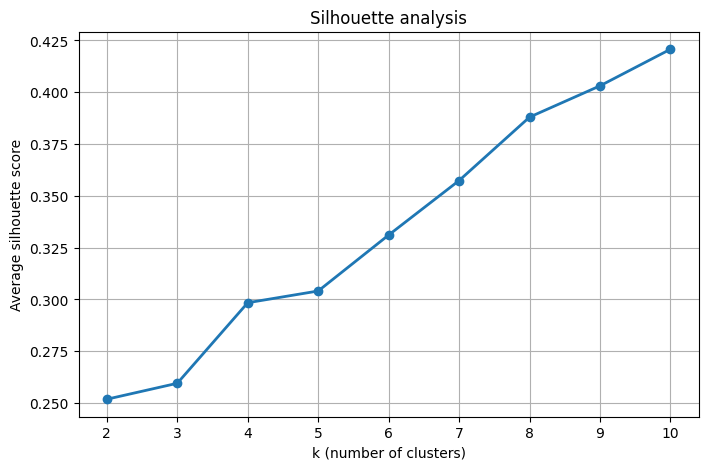

Best k by silhouette score: 10


In [11]:
# Cell 8 — Silhouette scores for k = 2..10
sil_scores = []
K_range2 = range(2, 11)
for k in K_range2:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k} -> silhouette score = {sil:.4f}")

plt.figure(figsize=(8,5))
plt.plot(list(K_range2), sil_scores, 'o-', linewidth=2)
plt.xlabel("k (number of clusters)")
plt.ylabel("Average silhouette score")
plt.title("Silhouette analysis")
plt.grid(True)
plt.show()

# pick best k by highest silhouette score
best_k = list(K_range2)[int(np.argmax(sil_scores))]
print("Best k by silhouette score:", best_k)


In [12]:
# Cell 9 — Fit final model using best_k (from silhouette) — fallback to 3 if something odd
k_final = int(best_k) if 'best_k' in globals() and best_k >= 2 else 3
print("Using k_final =", k_final)

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)

# attach cluster label back to original df rows used (be careful about dropped NA rows)
# We dropped rows when building X; get the index mapping
X_index = X.index  # original df indices that correspond to X
df_clusters = df.loc[X_index].copy()
df_clusters['cluster'] = labels

df_clusters.head()


Using k_final = 10


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender_encoded,cluster
0,1,Male,19,15,39,1,1
1,2,Male,21,15,81,1,1
2,3,Female,20,16,6,0,2
3,4,Female,23,16,77,0,8
4,5,Female,31,17,40,0,2


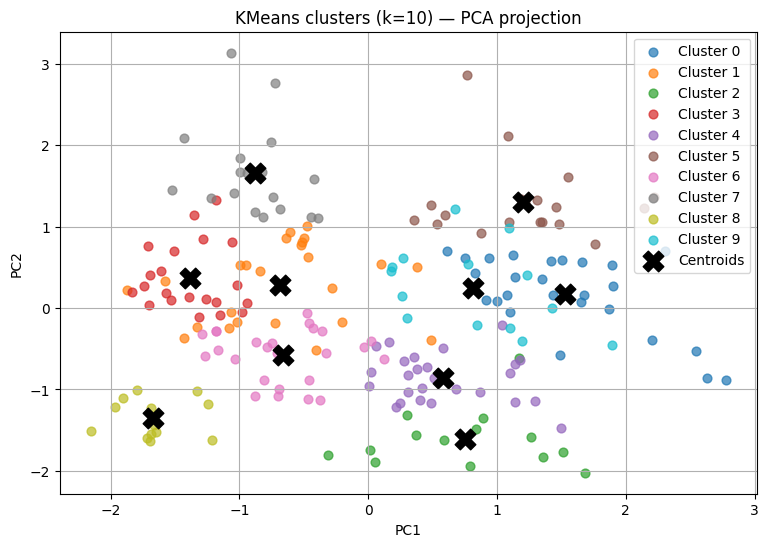

In [13]:
# Cell 10 — Plot clusters on PCA plane and centroids
centers_scaled = kmeans.cluster_centers_
centers_pca = pca.transform(centers_scaled)

plt.figure(figsize=(9,6))
for i in range(k_final):
    mask = df_clusters['cluster'] == i
    plt.scatter(X_pca[mask.values,0], X_pca[mask.values,1], s=40, alpha=0.7, label=f'Cluster {i}')
# centroids
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=220, c='black', label='Centroids')
plt.title(f'KMeans clusters (k={k_final}) — PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


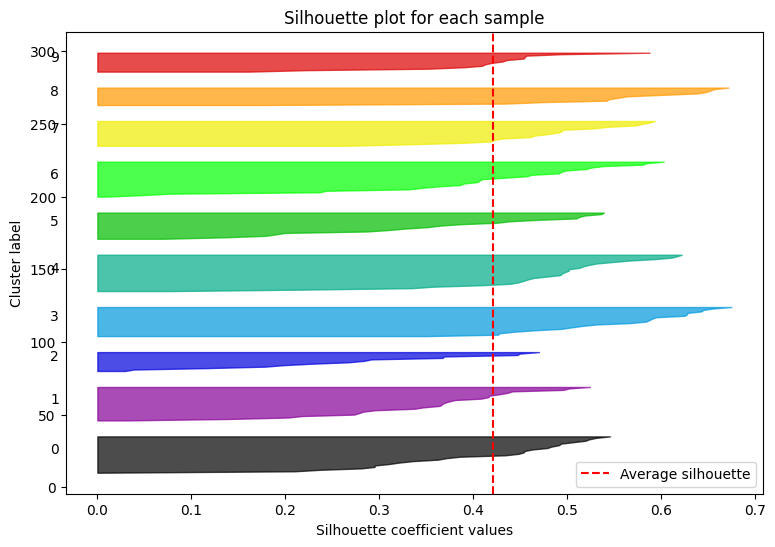

In [14]:
# Cell 11 — Per-sample silhouette plot (detailed)
from matplotlib import cm

cluster_labels = df_clusters['cluster'].values
sil_vals = silhouette_samples(X_scaled, cluster_labels)

y_lower = 10
plt.figure(figsize=(9,6))
for i in range(k_final):
    ith_sil_values = sil_vals[cluster_labels == i]
    ith_sil_values.sort()
    size_cluster_i = ith_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k_final)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_sil_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Silhouette plot for each sample")
plt.axvline(x=silhouette_score(X_scaled, cluster_labels), color="red", linestyle="--", label="Average silhouette")
plt.legend()
plt.show()


In [15]:
# Cell 12 — Cluster centroids (in original feature scale) & summaries
centroids_original_space = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids_original_space, columns=features)
centroid_df['cluster'] = range(k_final)
print("Cluster centroids (approx original scale):")
display(centroid_df)

# size of each cluster
print("Cluster sizes:")
print(df_clusters['cluster'].value_counts().sort_index())

# show average values per cluster (original df features)
cluster_summary = df_clusters.groupby('cluster')[features].mean().round(3)
display(cluster_summary)


Cluster centroids (approx original scale):


,Age,Annual Income (k$),Spending Score (1-100),Gender_encoded,cluster
0,58.846154,48.692308,39.846154,1.000000e+00,0
1,25.250000,41.250000,60.916667,1.000000e+00,1
2,41.214286,26.071429,20.142857,7.142857e-02,2
3,32.190476,86.047619,81.666667,-5.551115e-17,3
4,54.153846,54.230769,48.961538,0.000000e+00,4
5,38.473684,85.894737,14.210526,1.000000e+00,5
6,27.960000,57.360000,47.120000,0.000000e+00,6
7,33.277778,87.111111,82.666667,1.000000e+00,7
8,25.461538,25.692308,80.538462,-1.665335e-16,8
9,43.785714,93.285714,20.642857,-1.110223e-16,9


Cluster sizes:
cluster
0    26
1    24
2    14
3    21
4    26
5    19
6    25
7    18
8    13
9    14
Name: count, dtype: int64


,Age,Annual Income (k$),Spending Score (1-100),Gender_encoded
cluster,,,,
0,58.846,48.692,39.846,1.000
1,25.250,41.250,60.917,1.000
2,41.214,26.071,20.143,0.071
3,32.190,86.048,81.667,0.000
4,54.154,54.231,48.962,0.000
5,38.474,85.895,14.211,1.000
6,27.960,57.360,47.120,0.000
7,33.278,87.111,82.667,1.000
8,25.462,25.692,80.538,0.000


In [16]:
# Cell 13 — Save CSV with cluster labels and download
out_fname = "clustered_results.csv"
df_clusters.to_csv(out_fname, index=True)  # index keeps original row index
print("Saved:", out_fname)

from google.colab import files
files.download(out_fname)  # will trigger browser download


Saved: clustered_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>